# MLP on Simulated ORFs  
Start with ORF_MLP_118 which had the simulator bug fix.  
Evaluate MLP with wide,deep network.  
Train on copious simulated data.  
Use uniform but shorter RNA lengths: 500 
Lower accuracy: 66%.


In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-16 12:57:33 EDT


## Errors on first try
Went away by restarting Jupyter.

InternalError:  Blas xGEMM launch failed : a.shape=[1,32,84], b.shape=[1,84,128], m=32, n=128, k=84
	 [[node sequential_1/dense_4/MatMul (defined at home/jrm/venv/lib/python3.8/site-packages/keras/layers/core.py:1222) ]] [Op:__inference_train_function_1034]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_1/dense_4/MatMul:
 IteratorGetNext (defined at home/jrm/venv/lib/python3.8/site-packages/keras/engine/training.py:819)

Function call stack:
train_function


In [2]:
PC_TRAINS=50000
NC_TRAINS=50000
PC_TESTS=5000
NC_TESTS=5000   
RNA_LEN=500  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-16 12:57:33.541417: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import Collection_Generator, Transcript_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.RNA_gen import Collection_Generator, Transcript_Oracle
        from SimTools.KmerTools import KmerTools
BESTMODELPATH=DATAPATH+"BestModel"  # saved on cloud instance and lost after logout
LASTMODELPATH=DATAPATH+"LastModel"  # saved on Google Drive but requires login

CoLab not working. On my PC, use relative paths.


## Data Load


In [5]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")
pc_sim=None
nc_sim=None

2021-08-16 12:57:34 EDT
Generated 55000 PC seqs
Generated 55000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequence characteristics:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 500.0
Average ORF length: 336.34363636363634
NC seqs
Average RNA length: 500.0
Average ORF length: 126.28838181818182
2021-08-16 12:57:44 EDT


## Data Prep

In [7]:
def combine_pos_and_neg(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    return X,y
Xseq,y=combine_pos_and_neg(pc_all,nc_all)
print("The first few shuffled labels:")
print(y[:30])
pc_all=None
nc_all=None
show_time()

The first few shuffled labels:
[1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0]
2021-08-16 12:57:45 EDT


In [8]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    collection = []
    debug = 0
    for seq in seqs:
        counts = tool.make_dict_upto_K(max_K)
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
        if (debug<3):
            print(fdict)
            debug += 1;
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print("First few K-mer frequency matrices:")
print(Xfrq[:3])
Xseq = None
show_time()

{'A': 0.26, 'C': 0.24, 'G': 0.248, 'T': 0.252, 'AA': 0.0781563126252505, 'AC': 0.05410821643286573, 'AG': 0.056112224448897796, 'AT': 0.07214428857715431, 'CA': 0.05410821643286573, 'CC': 0.05811623246492986, 'CG': 0.05811623246492986, 'CT': 0.07014028056112225, 'GA': 0.06412825651302605, 'GC': 0.06412825651302605, 'GG': 0.07014028056112225, 'GT': 0.04809619238476954, 'TA': 0.06412825651302605, 'TC': 0.06412825651302605, 'TG': 0.06412825651302605, 'TT': 0.06012024048096192, 'AAA': 0.02610441767068273, 'AAC': 0.018072289156626505, 'AAG': 0.012048192771084338, 'AAT': 0.02208835341365462, 'ACA': 0.012048192771084338, 'ACC': 0.008032128514056224, 'ACG': 0.012048192771084338, 'ACT': 0.02208835341365462, 'AGA': 0.014056224899598393, 'AGC': 0.018072289156626505, 'AGG': 0.008032128514056224, 'AGT': 0.014056224899598393, 'ATA': 0.018072289156626505, 'ATC': 0.018072289156626505, 'ATG': 0.02208835341365462, 'ATT': 0.014056224899598393, 'CAA': 0.010040160642570281, 'CAC': 0.018072289156626505, 'CA

In [9]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 100000 = 100000
Reserved test set size= 10000 = 10000
2021-08-16 12:57:59 EDT


## Neural network

In [10]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10880     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)        

2021-08-16 12:57:59.453450: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 12:57:59.522229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-16 12:57:59.524090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-16 12:57:59.524154: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 12:57:59.530285: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-16 12:57:59.530369: I tensorflow/stream_executor

In [11]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    # No need to shuffle here assuming data was shuffled above.
    splitter = KFold(n_splits=SPLITS,shuffle=False) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-16 12:57:59 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200


2021-08-16 12:58:00.129884: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-16 12:58:00.149715: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-16 12:58:06.526413: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 157/2084 [=>............................] - ETA: 1s - loss: 0.7220 - accuracy: 0.5166 

2021-08-16 12:58:06.853090: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2084/2084 [==============================] - 9s 1ms/step - loss: 0.7049 - accuracy: 0.5026 - val_loss: 0.6934 - val_accuracy: 0.4976


2021-08-16 12:58:09.832303: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.5063 - val_loss: 0.6931 - val_accuracy: 0.5024
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5044 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 8/200
2084

Epoch 47/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6206 - accuracy: 0.6595 - val_loss: 0.6185 - val_accuracy: 0.6554
Epoch 48/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6218 - accuracy: 0.6529 - val_loss: 0.6188 - val_accuracy: 0.6528
Epoch 49/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6217 - accuracy: 0.6531 - val_loss: 0.6155 - val_accuracy: 0.6593
Epoch 50/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6210 - accuracy: 0.6568 - val_loss: 0.6171 - val_accuracy: 0.6605
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 51/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6215 - accuracy: 0.6539 - val_loss: 0.6146 - val_accuracy: 0.6606
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 52/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6188 - accuracy: 0.6566 - val_loss: 0.6155 - val_accuracy: 0.6608
INFO:tenso

2084/2084 [==============================] - 2s 1ms/step - loss: 0.6171 - accuracy: 0.6606 - val_loss: 0.6151 - val_accuracy: 0.6615
Epoch 100/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6149 - accuracy: 0.6612 - val_loss: 0.6136 - val_accuracy: 0.6606
Epoch 101/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6170 - accuracy: 0.6589 - val_loss: 0.6135 - val_accuracy: 0.6605
Epoch 102/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6160 - accuracy: 0.6618 - val_loss: 0.6158 - val_accuracy: 0.6582
Epoch 103/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6166 - accuracy: 0.6581 - val_loss: 0.6142 - val_accuracy: 0.6621
Epoch 104/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6156 - accuracy: 0.6606 - val_loss: 0.6148 - val_accuracy: 0.6586
Epoch 105/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6185 - accuracy: 0.6571 - val_loss: 0.6137 - val_ac

2084/2084 [==============================] - 2s 1ms/step - loss: 0.6132 - accuracy: 0.6617 - val_loss: 0.6136 - val_accuracy: 0.6614
Epoch 155/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6107 - accuracy: 0.6659 - val_loss: 0.6147 - val_accuracy: 0.6601
Epoch 156/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6165 - accuracy: 0.6583 - val_loss: 0.6135 - val_accuracy: 0.6616
Epoch 157/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6119 - accuracy: 0.6635 - val_loss: 0.6146 - val_accuracy: 0.6616
Epoch 158/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6160 - accuracy: 0.6622 - val_loss: 0.6137 - val_accuracy: 0.6615
Epoch 159/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6155 - accuracy: 0.6609 - val_loss: 0.6139 - val_accuracy: 0.6620
Epoch 160/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6141 - accuracy: 0.6625 - val_loss: 0.6153 - val_ac

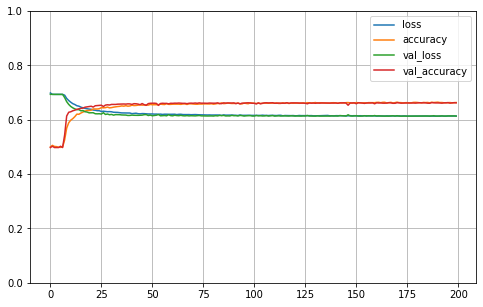

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7070 - accuracy: 0.4959 - val_loss: 0.6933 - val_accuracy: 0.5014
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6934 - accuracy: 0.4988 - val_loss: 0.6935 - val_accuracy: 0.5014
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.4986
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - a

2084/2084 [==============================] - 3s 1ms/step - loss: 0.6229 - accuracy: 0.6523 - val_loss: 0.6110 - val_accuracy: 0.6675
Epoch 54/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6246 - accuracy: 0.6497 - val_loss: 0.6089 - val_accuracy: 0.6681
Epoch 55/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6250 - accuracy: 0.6504 - val_loss: 0.6082 - val_accuracy: 0.6683
Epoch 56/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6267 - accuracy: 0.6499 - val_loss: 0.6076 - val_accuracy: 0.6681
Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6237 - accuracy: 0.6501 - val_loss: 0.6114 - val_accuracy: 0.6670
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6248 - accuracy: 0.6490 - val_loss: 0.6097 - val_accuracy: 0.6689
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.

2084/2084 [==============================] - 3s 1ms/step - loss: 0.6190 - accuracy: 0.6574 - val_loss: 0.6084 - val_accuracy: 0.6662
Epoch 108/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6200 - accuracy: 0.6569 - val_loss: 0.6074 - val_accuracy: 0.6698
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 109/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6185 - accuracy: 0.6569 - val_loss: 0.6073 - val_accuracy: 0.6689
Epoch 110/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6191 - accuracy: 0.6543 - val_loss: 0.6069 - val_accuracy: 0.6695
Epoch 111/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6174 - accuracy: 0.6593 - val_loss: 0.6073 - val_accuracy: 0.6690
Epoch 112/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6202 - accuracy: 0.6555 - val_loss: 0.6066 - val_accuracy: 0.6697
Epoch 113/200
2084/2084 [==============================] - 3s 1ms/step - lo

Epoch 161/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6164 - accuracy: 0.6596 - val_loss: 0.6083 - val_accuracy: 0.6695
Epoch 162/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6182 - accuracy: 0.6593 - val_loss: 0.6068 - val_accuracy: 0.6683
Epoch 163/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6192 - accuracy: 0.6557 - val_loss: 0.6072 - val_accuracy: 0.6700
Epoch 164/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6179 - accuracy: 0.6583 - val_loss: 0.6060 - val_accuracy: 0.6698
Epoch 165/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6169 - accuracy: 0.6595 - val_loss: 0.6064 - val_accuracy: 0.6695
Epoch 166/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6180 - accuracy: 0.6578 - val_loss: 0.6075 - val_accuracy: 0.6694
Epoch 167/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6165 - accuracy: 0.6596 - val_loss: 0

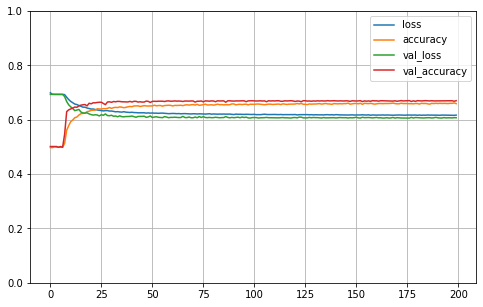

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7052 - accuracy: 0.5013 - val_loss: 0.6943 - val_accuracy: 0.5007
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6935 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.4993
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6934 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6932 - val_accuracy: 0.4993
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6206 - accuracy: 0.6529 - val_loss: 0.6122 - val_accuracy: 0.6643
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6217 - accuracy: 0.6550 - val_loss: 0.6139 - val_accuracy: 0.6645
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6225 - accuracy: 0.6557 - val_loss: 0.6147 - val_accuracy: 0.6652
Epoch 60/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6220 - accuracy: 0.6547 - val_loss: 0.6122 - val_accuracy: 0.6656
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6208 - accuracy: 0.6552 - val_loss: 0.6127 - val_accuracy: 0.6653
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6206 - accuracy: 0.6530 - val_loss: 0.6121 - val_accuracy: 0.6647
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6208 - accuracy: 0.6541 - val_loss: 0.6120 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.6195 - accuracy: 0.6559 - val_loss: 0.6116 - val_accuracy: 0.6656
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6176 - accuracy: 0.6562 - val_loss: 0.6109 - val_accuracy: 0.6655
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6165 - accuracy: 0.6596 - val_loss: 0.6127 - val_accuracy: 0.6659
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6170 - accuracy: 0.6580 - val_loss: 0.6127 - val_accuracy: 0.6659
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6169 - accuracy: 0.6573 - val_loss: 0.6114 - val_accuracy: 0.6649
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6191 - accuracy: 0.6578 - val_loss: 0.6112 - val_accuracy: 0.6659
Epoch 119/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6177 - accuracy: 0.6580 - val_loss: 0.6117 - val_ac

Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6157 - accuracy: 0.6599 - val_loss: 0.6113 - val_accuracy: 0.6653
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6184 - accuracy: 0.6565 - val_loss: 0.6111 - val_accuracy: 0.6654
Epoch 171/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6159 - accuracy: 0.6612 - val_loss: 0.6108 - val_accuracy: 0.6653
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6145 - accuracy: 0.6614 - val_loss: 0.6110 - val_accuracy: 0.6654
Epoch 173/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6131 - accuracy: 0.6633 - val_loss: 0.6107 - val_accuracy: 0.6652
Epoch 174/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6133 - accuracy: 0.6634 - val_loss: 0.6115 - val_accuracy: 0.6648
Epoch 175/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6145 - accuracy: 0.6612 - val_loss: 0

In [ ]:
show_time()
last_model = do_cross_validation(X_train,y_train)
best_model = load_model(BESTMODELPATH)

In [ ]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


In [ ]:
print("Accuracy on training data.")
show_time()
show_test_AUC(best_model,X_train,y_train)
show_test_accuracy(best_model,X_train,y_train)
show_time()

In [ ]:
print("Accuracy on test data.")
show_time()
show_test_AUC(last_model,X_test,y_test)
show_test_accuracy(last_model,X_test,y_test)
show_time()